# Re-exécution pour modifier les légendes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
#from matplotlib.mlab import frange
import statistics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from imblearn.metrics import specificity_score
from imblearn.metrics import sensitivity_score
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from datetime import datetime

import sys
sys.path.append('../../../../../')
from metrics import utilities_functions as uf
u_functions = uf.functions()

## Chargement du jeu de données Shuttle

Shuttle contient 10 attributs dont le dernier est la classe à expliquer.
Il y a 46464 observations dont 878 anormales.
Avec le dernier attribut, nous avons les classes "o" pour les anomalies et "n" pour les observations normales.

In [2]:
data_brut_Shuttle = pd.read_csv('../../../../../datasets/datasets_publics/shuttle-unsupervised-ad_2019-06-14 17:33:02.493755.csv', header=None, index_col=None)
X_Shuttle = data_brut_Shuttle[[0, 1, 2, 3, 4, 5, 6, 7, 8]]
y_brut_Shuttle = data_brut_Shuttle[[9]]
data_brut_Shuttle.describe()

,0,1,2,3,4,5,6,7,8
count,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000
mean,44.775482,-0.712509,84.834108,0.279291,38.652763,2.289708,40.070334,46.180419,6.299888
std,8.753404,44.218007,8.731175,37.317203,15.902506,177.518356,10.969455,17.052467,15.005878
min,27.000000,-4475.000000,21.000000,-3939.000000,-188.000000,-12809.000000,-26.000000,-353.000000,-356.000000
25%,37.000000,0.000000,79.000000,0.000000,34.000000,-4.000000,34.000000,35.000000,0.000000
50%,43.000000,0.000000,83.000000,0.000000,42.000000,0.000000,39.000000,41.000000,2.000000
75%,49.000000,0.000000,87.000000,0.000000,46.000000,5.000000,43.000000,52.000000,2.000000
max,123.000000,1963.000000,149.000000,3830.000000,436.000000,15164.000000,105.000000,270.000000,266.000000


## Transformation de la classe à expliquer

L'objectif ici est de remplacer les "o" par -1 et les "n" par 1 afin de faire les matrices de confusion avec la fonction dédiée de scikit-learn.

In [3]:
y_transform_Shuttle = y_brut_Shuttle
y_transform_Shuttle = np.where(y_transform_Shuttle=='o',-1,1)
#y_transform

## General Parameters

In [4]:
data_name = "Shuttle"
method_name = "IForest"
execution_object = "InconstanceAnalysis"
save_fig=False

In [5]:
'''
    Fonction pour sauvegarder les résultats de l'exécution dans un fichier .csv
    data : un tableau de plusieurs colonnes à concatener
    names : les noms des colonnes dont les valeurs ont été fournies dans data
'''
def save_results_data(data:[], names:[], data_name, method_name):
    if len(data) !=  len(names) or len(data) == 0:
        print("Error : Data do not contains any value OR Every column in data must have its own name in names.")
    else:
        #for i in range(0, len(data), 1) :
            
        #d = np.array(names[i]:data[i] for i in range(0, len(data), 1))
        d = {names[i]:data[i] for i in range(0, len(data), 1)}
        dataset = pd.DataFrame(d, columns=names)
        print(dataset)

        datetime_now = str(datetime.now()) 
        datetime_now = datetime_now.replace(".", ":")
        file_name = str(method_name)+"_"+str(data_name)+"_"+datetime_now+".csv"
        print("File name to use = "+file_name)
        # Save dataset
        dataset.to_csv(file_name, index=None, header=True)
        print("Data well saved in = "+file_name)
    return file_name

In [6]:
'''
    Fonction pour afficher le graphique
'''
def plot_with_data(file_name, x_name, x_column:int, y_name, y_column:int, z_name, z_column:int, 
                   title, version, n_dimensions = 2):
    # This is to plot the data using the given file.
    # Extract data from the file considering the number of dimension
    import sys
    sys.path.append('../../../../../')
    from datasets import datasets as datat
    dts = datat.synthetic_datasets(path_top="../../../../../")
    
    #dataset_new = datat.load_data_without_split(file_name)
    dataset_new = datat.load_data_from_CSV(file_name)
    print(dataset_new.describe())
    print()
    print(dataset_new)
    if n_dimensions == 2 :
        plt.plot(dataset_new[x_column], dataset_new[y_column], "y-", marker='o', markerfacecolor='black', markersize=5, color='black')
        plt.title(title)
        plt.xlabel(str(x_name))
        plt.ylabel(str(y_name))
        plt.legend(loc="best")
        plt.show()
        
    #file_name2 = file_name+".png"
    #plt.savefig(file_name2)
    #print("Figure well saved in File name = "+file_name2)

## Shuttle

### Exécution de Isolation Forest sur le jeux de données Shuttle en faisant varier n_estimators

### Etude de l'inconstance de IForest
Utilisant les valeurs par défaut des paramètres de IForest au niveau de scikit-learn

In [7]:
study_executions_time_IF_Shuttle = []
study_roc_auc_IF_Shuttle = []
study_recalls_IF_Shuttle = []
study_specificity_IF_Shuttle = []
study_execution_number_IF_Shuttle = []

for j in range(1, 11, 1):
    study_execution_number_IF_Shuttle.append(j)
    start_IF_Shuttle = time()
        
    # Instanciation, fit and predict on Shuttle
    study_func_IF_Shuttle = IsolationForest(behaviour="new")
    study_func_IF_Shuttle.fit(X_Shuttle)
    study_y_pred_IF_Shuttle = study_func_IF_Shuttle.predict(X_Shuttle)

    # Calcul du temps d'exécution
    study_exec_time_IF_Shuttle = time() - start_IF_Shuttle
    study_executions_time_IF_Shuttle.append(study_exec_time_IF_Shuttle)
    
    # Recall
    study_recalls_IF_Shuttle.append(recall_score(y_transform_Shuttle, study_y_pred_IF_Shuttle))
    
    # Specificity
    study_specificity_IF_Shuttle.append(specificity_score(y_transform_Shuttle, study_y_pred_IF_Shuttle))
    
    # Calcul de l'aire sous la courbe ROC
    study_y_DF_IF_Shuttle = study_func_IF_Shuttle.decision_function(X_Shuttle)
    study_auc_IF_Shuttle = roc_auc_score(y_transform_Shuttle, study_y_DF_IF_Shuttle)
    study_roc_auc_IF_Shuttle.append(study_auc_IF_Shuttle)

/Users/maurrastogbe/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/Users/maurrastogbe/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/Users/maurrastogbe/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/Users/maurrastogbe/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/Users/maurrastogbe/opt/anaconda3/lib/python3.7/site-packages/sklear

In [8]:
'''
    Ajouter les données dans un tableau
    Sauvegarder les données dans un fichier .csv
'''
data = []
names = []
names.append("Execution Number")
data.append(study_execution_number_IF_Shuttle)
names.append("CPU Time(s)")
data.append(study_executions_time_IF_Shuttle)
names.append("ROC AUC")
data.append(study_roc_auc_IF_Shuttle)
names.append("Recall")
data.append(study_recalls_IF_Shuttle)
names.append("Specificity")
data.append(study_specificity_IF_Shuttle)

print(names)
print(data)
#data_file_name = save_results_data(data=data, names=names, data_name="IForest", method_name="Shuttle")
data_file_name = u_functions.save_results_data(data=data, names=names, data_name=data_name, method_name=method_name,
                                               execution_object=execution_object)

['Execution Number', 'CPU Time(s)', 'ROC AUC', 'Recall', 'Specificity']
[[1, 2, 3, 4, 5], [2.5700478553771973, 2.3647871017456055, 2.315784215927124, 2.393923044204712, 2.242767095565796], [0.9978492927383392, 0.9975513752723707, 0.9971533941154255, 0.9981499585204145, 0.996979200843643], [0.9425700873075067, 0.9431623744131971, 0.9252182687667266, 0.9357697538718027, 0.9123415083578291], [0.9863325740318907, 0.9851936218678815, 0.9806378132118451, 0.9863325740318907, 0.9840546697038725]]
   Execution Number  CPU Time(s)   ROC AUC    Recall  Specificity
0                 1     2.570048  0.997849  0.942570     0.986333
1                 2     2.364787  0.997551  0.943162     0.985194
2                 3     2.315784  0.997153  0.925218     0.980638
3                 4     2.393923  0.998150  0.935770     0.986333
4                 5     2.242767  0.996979  0.912342     0.984055
directory_path = Figures/2020-10-04/InconstanceAnalysis/IForest
Data well saved in = Figures/2020-10-04/Incons

        0                  1                   2                   3  \
count   5                  5                   5                   5   
unique  5                  5                   5                   5   
top     4  2.393923044204712  0.9981499585204145  0.9431623744131971   
freq    1                  1                   1                   1   

                         4  
count                    5  
unique                   4  
top     0.9863325740318907  
freq                     2  

   0                   1                   2                   3  \
1  1  2.5700478553771973  0.9978492927383392  0.9425700873075067   
2  2  2.3647871017456055  0.9975513752723707  0.9431623744131971   
3  3   2.315784215927124  0.9971533941154255  0.9252182687667266   
4  4   2.393923044204712  0.9981499585204145  0.9357697538718027   
5  5   2.242767095565796   0.996979200843643  0.9123415083578291   

                    4  
1  0.9863325740318907  
2  0.9851936218678815  
3  0.9806378

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

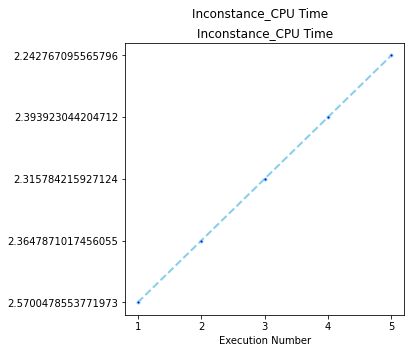

In [9]:
## Evolution de CPU Time
u_functions.plot_with_data(file_name=data_file_name, x_name="Execution Number", x_column = 0,
               y_name = "CPU Time(s)", y_column=1, z_name="NULL", z_column="NULL", 
                   title="Inconstance_CPU Time", version="Shuttle", n_dimensions = 2, save_fig=save_fig)

In [ ]:
# Evolution du ROC AUC

u_functions.plot_with_data(file_name=data_file_name, x_name="Execution Number", x_column = 0,
               y_name = 'ROC AUC', y_column=2, z_name="NULL", z_column="NULL", 
                   title="Inconstance_ROC AUC", version="Shuttle", n_dimensions = 2, save_fig=save_fig)

In [ ]:
# Evolution du rappel

u_functions.plot_with_data(file_name=data_file_name, x_name="Execution Number", x_column = 0,
               y_name = 'Recall', y_column=3, z_name="NULL", z_column="NULL", 
                   title="Inconstance_Recall", version="Shuttle", n_dimensions = 2, save_fig=save_fig)

In [ ]:
# Evolution de spécificité

u_functions.plot_with_data(file_name=data_file_name, x_name="Execution Number", x_column = 0,
               y_name = 'Specificity', y_column=4, z_name="NULL", z_column="NULL", 
                   title="Inconstance_Specificity", version="Shuttle", n_dimensions = 2, save_fig=save_fig)

#### Conclusion
Malgré le caractère aléatoire de IForest, les métrics choisis ont tendance à être constant durant l'exécution successive avec les mêmes paramètres.